# Sine Wave Feature Engineering

In this notebook, I will implement sine waves over the various features of price action, including open, high, low, and close. I will also investigate implementation over various time periods, such as 30 day, 24 hour, and 30 minute. I will include a fit regression sine wave as well as a mesa sine wave. 

As a sidenote, I may ensure proper encoding of the volume feature in a scaled manner. Furthermore, I will consider the optimal data formulation, whether it should be encoded as images for cnn training or as columns of linear data for a more basic linear regression. 


To do:
1. Apply Mesa sine wave to open, high, low, close
2. Rolling apply sine wave fit to 4 periods
    A. Calculate angle in radians
    B. Compute current and next sin and cos features
3. Investigate Relationships using Linear Model
4. Implement complex relationships 
    
3. Fit on P(4,3) = 12 features  
    A. Attempt to return relevant values; if not, return at least the current angle  
    B. Should also return the form of the function for future calculations  
    C. Return the next expected angle given the fit function  
4. Apply mesa sine wave on features as well, up to 12
5. Check volume to ensure standard scaling
6. Given angle use solved sine function to generate next prediction return
7. Test p-values using statsmodels

In [1]:
from sine_modules import *
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [34]:
pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", 100)

key_name = 'top100alpha.csv'
data_dir = './data/screens/1yeartopperformers/'

tail = '190820.pickle'
#tail = stock + suffix

key_df = pd.read_csv(data_dir+key_name)
key_df.head()

,SYMBOL,mean,std,alpha
0,DOCU,0.669910,3.329333,0.201214
1,APG,0.542511,2.696561,0.201186
2,PRTS,1.168491,6.005884,0.194558
3,TSLA,0.973406,5.113792,0.190349
4,DKNG,0.951621,5.210704,0.182628


In [35]:
df = load_set('DOCU', data_dir, tail)

In [36]:
df.head()

,open,high,low,close,volume,date,SYMBOL,prev_close,diff_1,pct_change,log_return
252,213.490,213.53,207.6881,209.47,2763874,2020-08-18,DOCU,207.70,1.77,0.008522,0.008486
251,202.240,209.83,201.9800,207.70,2590486,2020-08-17,DOCU,199.71,7.99,0.040008,0.039228
250,201.355,204.46,197.2100,199.71,1952648,2020-08-14,DOCU,199.38,0.33,0.001655,0.001654
249,194.220,203.85,193.6200,199.38,4048023,2020-08-13,DOCU,193.30,6.08,0.031454,0.030969
248,192.650,196.88,189.1200,193.30,4591084,2020-08-12,DOCU,191.82,1.48,0.007716,0.007686


In [37]:
df['open'].diff(-1) / df['open'].shift(-1)

252    0.055627
251    0.004395
250    0.036737
249    0.008149
248   -0.024606
         ...   
4     -0.014998
3      0.007556
2      0.014427
1     -0.027406
0           NaN
Name: open, Length: 253, dtype: float64

In [38]:
(213.490 - 202.240) / 202.240

0.055626977848101264

In [39]:
df['open'][::-1].rolling(2).mean()[::-1]

252    207.8650
251    201.7975
250    197.7875
249    193.4350
248    195.0800
         ...   
4       45.0000
3       45.1700
2       44.6800
1       44.9850
0           NaN
Name: open, Length: 253, dtype: float64

#### 1. Apply Mesa sine wave to open, high, low, close

In [40]:
cols = ['open','high','low','close']

for col in cols:
    # setup % change columns
    df['%{}'.format(col)] = df[col].diff(-1) / df[col].shift(-1)
    
    # Apply Mesa sine wave to columns
    df['mesa_{}'.format(col)] = df[col][::-1].rolling(5).apply(mesa_wave, raw=True)[::-1]

In [41]:
df.tail(252)

,open,high,low,close,volume,date,SYMBOL,prev_close,diff_1,pct_change,log_return,%open,mesa_open,%high,mesa_high,%low,mesa_low,%close,mesa_close
251,202.240,209.83,201.980,207.70,2590486,2020-08-17,DOCU,199.71,7.99,0.040008,0.039228,0.004395,0.491632,0.026264,0.505999,0.024187,0.507808,0.040008,0.522800
250,201.355,204.46,197.210,199.71,1952648,2020-08-14,DOCU,199.38,0.33,0.001655,0.001654,0.036737,0.482632,0.002992,0.477490,0.018541,0.497680,0.001655,0.484187
249,194.220,203.85,193.620,199.38,4048023,2020-08-13,DOCU,193.30,6.08,0.031454,0.030969,0.008149,0.455347,0.035402,0.476116,0.023794,0.482531,0.031454,0.483867
248,192.650,196.88,189.120,193.30,4591084,2020-08-12,DOCU,191.82,1.48,0.007716,0.007686,-0.024606,0.428060,-0.014812,0.432980,-0.011809,0.441392,0.007716,0.451330
247,197.510,199.84,191.380,191.82,4488571,2020-08-11,DOCU,198.38,-6.56,-0.033068,-0.033627,-0.042886,0.439907,-0.037363,0.441455,-0.011467,0.429088,-0.033068,0.425658
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,44.660,45.24,43.770,43.98,1247518,2019-08-23,DOCU,44.75,-0.77,-0.017207,-0.017356,-0.014998,0.474036,-0.002206,0.480280,-0.010176,0.481506,-0.017207,0.483547
3,45.340,45.34,44.220,44.75,1254571,2019-08-22,DOCU,45.02,-0.27,-0.005997,-0.006015,0.007556,NaN,-0.011770,NaN,-0.009852,NaN,-0.005997,NaN
2,45.000,45.88,44.660,45.02,1259584,2019-08-21,DOCU,44.63,0.39,0.008739,0.008701,0.014427,NaN,0.020690,NaN,0.021150,NaN,0.008739,NaN
1,44.360,44.95,43.735,44.63,1911594,2019-08-20,DOCU,44.54,0.09,0.002021,0.002019,-0.027406,NaN,-0.022614,NaN,-0.013311,NaN,0.002021,NaN


#### 2. Rolling apply sine wave fit and return next prediction

In my original conception, I did not want to throw away the calculations that I was creating on every pass of the function. 

This section of the notebook now simple predicts the next expected return using the sine wave on the 4 values. 

Commented code as been inserted if the other extraneous aspects of the function are still desired at a later date. 

In [42]:
def fit_sine(x):
    '''Fit sin to the input time sequence, 
    and return fitting parameters "amp", "omega", "phase", "offset", "freq", "period" and "fitfunc"'''
    # y = x.index
    yy = numpy.array(x)
    tt = numpy.array(x.index.values)
    ff = numpy.fft.fftfreq(len(tt), (tt[1]-tt[0]))   # assume uniform spacing
    Fyy = abs(numpy.fft.fft(yy))
    guess_freq = abs(ff[numpy.argmax(Fyy[1:])+1])   # excluding the zero frequency "peak", which is related to offset
    guess_amp = numpy.std(yy) * 2.**0.5
    guess_offset = numpy.mean(yy)
    guess = numpy.array([guess_amp, 2.*numpy.pi*guess_freq, 0., guess_offset])

    def sinfunc(t, A, w, p, c):  return A *numpy.sin(w*t + p) + c
    
    popt, pcov = scipy.optimize.curve_fit(sinfunc, tt, yy, p0=guess, maxfev=5000)
    A, w, p, c = popt
    f = w/(2.*numpy.pi)
    fitfunc = lambda t: A * numpy.sin(w*t + p) + c
    
    # Original return function
    # Needs to be modified to return a single number value
#     return {"amp": A, 
#             "omega": w, 
#             "phase": p, 
#             "offset": c, 
#             "freq": f, 
#             "period": 1./f, 
#             "fitfunc": fitfunc, 
#             "maxcov": numpy.max(pcov),}, #index=[x.index.values[0]]
#             "rawres": (guess,popt,pcov)}
    #print(tt[0], tt[0]+1)
    
    ### Use this section if you want to insert the extraneous features into the external dataframe ### 
    internal = pd.Series({"amp": A, 
                "omega": w, 
                "phase": p, 
                "offset": c, 
                "freq": f, 
                "period": 1./f, 
                "fitfunc": fitfunc, 
                "maxcov": numpy.max(pcov)})
    df.loc[tt[-1], internal.index] = internal
    ### ---------- ### 
    
    return fitfunc(tt[-1])

In [43]:
cols = ['open','high','low','close']

for col in cols:
    
    # add the statistic columns to the dataframe with the correct name 
    new_cols = ["amp", "omega", "phase", "offset","freq","period","fitfunc","maxcov"]
    for new in new_cols:
        df[new] = pd.Series()
    
    
    df['{}_sin'.format(col)] = df['%{}'.format(col)][::-1].dropna().rolling(25).apply(fit_sine, raw=False)[::-1]
    df.rename({new:'{}_{}'.format(col, new) for new in new_cols}, axis=1, inplace=True)
    df['time'] = df.index
    
    df['{}_angle'.format(col)] = df['{}_omega'.format(col)] * df['time'].astype(int) + df['{}_phase'.format(col)]
    
    df['{}_rad'.format(col)] = np.remainder(df['{}_angle'.format(col)], 2*np.pi)
    
    df['{}_rad2'.format(col)] = df['{}_omega'.format(col)] / (2*np.pi) + df['{}_rad'.format(col)]
    df['{}_sin2'.format(col)] = df['{}_amp'.format(col)] * np.sin(df['{}_rad2'.format(col)]) + df['{}_offset'.format(col)]
    df['{}_cos2'.format(col)] = np.cos(df['{}_rad2'.format(col)])
    df['{}_cos'.format(col)] = np.cos(df['{}_rad'.format(col)])
    df['{}_tan'.format(col)] = np.tan(df['{}_rad'.format(col)])
    df['{}_tan2'.format(col)] = np.tan(df['{}_rad2'.format(col)])
    
    df['{}_xsinx'.format(col)] = df['%{}'.format(col)] * df['{}_sin'.format(col)]
    df['{}_xcosx'.format(col)] = df['%{}'.format(col)] * df['{}_cos'.format(col)]
    df['{}_sinxcosx'.format(col)] = df['{}_sin'.format(col)] * df['{}_cos'.format(col)]
    df['{}_xsinxcosx'.format(col)] =df['%{}'.format(col)] * df['{}_sin'.format(col)] * df['{}_cos'.format(col)]
    
    df['{}_xsinx2'.format(col)] = df['%{}'.format(col)] * df['{}_sin2'.format(col)]
    df['{}_xcosx2'.format(col)] = df['%{}'.format(col)] * df['{}_cos2'.format(col)]
    df['{}_sinxcosx2'.format(col)] = df['{}_sin2'.format(col)] * df['{}_cos2'.format(col)]
    df['{}_xsinxcosx2'.format(col)] =df['%{}'.format(col)] * df['{}_sin2'.format(col)] * df['{}_cos2'.format(col)]
    
    df['{}_xtanx'.format(col)] = df['%{}'.format(col)] * df['{}_tan'.format(col)]
    df['{}_xtanx2'.format(col)] = df['%{}'.format(col)] * df['{}_tan2'.format(col)]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  
/opt/conda/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


In [44]:
df.head()

,open,high,low,close,volume,date,SYMBOL,prev_close,diff_1,pct_change,log_return,%open,mesa_open,%high,mesa_high,%low,mesa_low,%close,mesa_close,open_amp,open_omega,open_phase,open_offset,open_freq,open_period,open_fitfunc,open_maxcov,open_sin,time,open_angle,open_rad,open_rad2,open_sin2,open_cos2,open_cos,open_tan,open_tan2,open_xsinx,open_xcosx,open_sinxcosx,open_xsinxcosx,open_xsinx2,open_xcosx2,open_sinxcosx2,open_xsinxcosx2,open_xtanx,open_xtanx2,high_amp,high_omega,high_phase,...,low_freq,low_period,low_fitfunc,low_maxcov,low_sin,low_angle,low_rad,low_rad2,low_sin2,low_cos2,low_cos,low_tan,low_tan2,low_xsinx,low_xcosx,low_sinxcosx,low_xsinxcosx,low_xsinx2,low_xcosx2,low_sinxcosx2,low_xsinxcosx2,low_xtanx,low_xtanx2,close_amp,close_omega,close_phase,close_offset,close_freq,close_period,close_fitfunc,close_maxcov,close_sin,close_angle,close_rad,close_rad2,close_sin2,close_cos2,close_cos,close_tan,close_tan2,close_xsinx,close_xcosx,close_sinxcosx,close_xsinxcosx,close_xsinx2,close_xcosx2,close_sinxcosx2,close_xsinxcosx2,close_xtanx,close_xtanx2
252,213.490,213.53,207.6881,209.47,2763874,2020-08-18,DOCU,207.70,1.77,0.008522,0.008486,0.055627,0.532009,0.017633,0.526410,0.028261,0.528548,0.008522,0.523033,0.029717,0.598270,-23.056626,0.001498,0.095218,10.502265,<function fit_sine.<locals>.<lambda> at 0x7f0f...,61.570818,0.027955,252,127.707302,2.043595,2.138813,0.026548,-0.537961,-0.455380,-1.955064,-1.566971,0.001555,-0.025331,-0.012730,-0.000708,0.001477,-0.029925,-0.014282,-0.000794,-0.108754,-0.087166,0.025113,0.626516,-29.683350,...,0.093776,10.663751,<function fit_sine.<locals>.<lambda> at 0x7f0f...,59.764689,0.022105,128.063336,2.399630,2.493406,0.019991,-0.797180,-0.737144,-0.916694,-0.757347,0.000625,-0.020832,-0.016295,-0.000460,0.000565,-0.022529,-0.015937,-0.000450,-0.025906,-0.021403,0.027976,0.633014,-30.959737,-0.000597,0.100747,9.925827,<function fit_sine.<locals>.<lambda> at 0x7f0f...,60.128416,0.006203,128.559740,2.896034,2.996781,0.003440,-0.989533,-0.970002,-0.250616,-0.145832,0.000053,-0.008266,-0.006017,-0.000051,0.000029,-0.008433,-0.003404,-0.000029,-0.002136,-0.001243
251,202.240,209.83,201.9800,207.70,2590486,2020-08-17,DOCU,199.71,7.99,0.040008,0.039228,0.004395,0.491632,0.026264,0.505999,0.024187,0.507808,0.040008,0.522800,-0.032729,0.646575,24.979554,-0.002896,0.102906,9.717641,<function fit_sine.<locals>.<lambda> at 0x7f0f...,67.830023,0.027903,251,187.269925,5.057551,5.160457,0.026603,0.433225,0.338349,-2.781210,-2.080411,0.000123,0.001487,0.009441,0.000041,0.000117,0.001904,0.011525,0.000051,-0.012224,-0.009144,-0.028379,0.653468,23.465471,...,0.098401,10.162455,<function fit_sine.<locals>.<lambda> at 0x7f0f...,49.408026,0.026797,127.738565,2.074858,2.173260,0.025262,-0.566674,-0.482986,-1.812945,-1.453997,0.000648,-0.011682,-0.012943,-0.000313,0.000611,-0.013706,-0.014315,-0.000346,-0.043850,-0.035168,0.026840,0.581931,-18.511150,0.001094,0.092617,10.797136,<function fit_sine.<locals>.<lambda> at 0x7f0f...,86.590047,0.026580,127.553464,1.889758,1.982375,0.025692,-0.400056,-0.313580,-3.028129,-2.290904,0.001063,-0.012546,-0.008335,-0.000333,0.001028,-0.016005,-0.010278,-0.000411,-0.121149,-0.091654
250,201.355,204.46,197.2100,199.71,1952648,2020-08-14,DOCU,199.38,0.33,0.001655,0.001654,0.036737,0.482632,0.002992,0.477490,0.018541,0.497680,0.001655,0.484187,-0.032290,0.644606,25.404139,-0.000563,0.102592,9.747331,<function fit_sine.<locals>.<lambda> at 0x7f0f...,72.028098,0.029552,250,186.555563,4.343189,4.445781,0.030587,-0.263461,-0.360870,2.584359,3.661533,0.001086,-0.013257,-0.010664,-0.000392,0.001124,-0.009679,-0.008058,-0.000296,0.094941,0.134513,-0.026344,0.657144,22.583851,...,0.101455,9.856606,<function fit_sine.<locals>.<lambda> at 0x7f0f...,54.565566,0.032622,186.959666,4.747292,4.848747,0.032323,0.135936,0.034896,-28.638930,-7.288121,0.000605,0.000647,0.001138,0.000021,0.000599,0.002520,0.004394,0.000081,-0.531008,-0.135132,-0.030449,0.642112,26.634865,-0.002859,0.102195,9.785190,<fun

In [45]:
drop_cols = []
for column in df.columns:
    if 'fitfunc' in column:
        drop_cols.append(column)
        
drop_cols

['open_fitfunc', 'high_fitfunc', 'low_fitfunc', 'close_fitfunc']

In [46]:
sym = df.loc[0,'SYMBOL']
suffix = '25082020.pickle'
df.drop(drop_cols, axis=1).to_pickle('./data/prepared/engineered/{}{}'.format(sym, suffix))

In [47]:
loader = './data/prepared/engineered/'
pd.read_pickle('{}{}{}'.format(loader,sym,suffix))

,open,high,low,close,volume,date,SYMBOL,prev_close,diff_1,pct_change,log_return,%open,mesa_open,%high,mesa_high,%low,mesa_low,%close,mesa_close,open_amp,open_omega,open_phase,open_offset,open_freq,open_period,open_maxcov,open_sin,time,open_angle,open_rad,open_rad2,open_sin2,open_cos2,open_cos,open_tan,open_tan2,open_xsinx,open_xcosx,open_sinxcosx,open_xsinxcosx,open_xsinx2,open_xcosx2,open_sinxcosx2,open_xsinxcosx2,open_xtanx,open_xtanx2,high_amp,high_omega,high_phase,high_offset,...,low_phase,low_offset,low_freq,low_period,low_maxcov,low_sin,low_angle,low_rad,low_rad2,low_sin2,low_cos2,low_cos,low_tan,low_tan2,low_xsinx,low_xcosx,low_sinxcosx,low_xsinxcosx,low_xsinx2,low_xcosx2,low_sinxcosx2,low_xsinxcosx2,low_xtanx,low_xtanx2,close_amp,close_omega,close_phase,close_offset,close_freq,close_period,close_maxcov,close_sin,close_angle,close_rad,close_rad2,close_sin2,close_cos2,close_cos,close_tan,close_tan2,close_xsinx,close_xcosx,close_sinxcosx,close_xsinxcosx,close_xsinx2,close_xcosx2,close_sinxcosx2,close_xsinxcosx2,close_xtanx,close_xtanx2
252,213.490,213.53,207.6881,209.47,2763874,2020-08-18,DOCU,207.70,1.77,0.008522,0.008486,0.055627,0.532009,0.017633,0.526410,0.028261,0.528548,0.008522,0.523033,0.029717,0.598270,-23.056626,0.001498,0.095218,10.502265,61.570818,0.027955,252,127.707302,2.043595,2.138813,0.026548,-0.537961,-0.455380,-1.955064,-1.566971,0.001555,-0.025331,-0.012730,-0.000708,0.001477,-0.029925,-0.014282,-0.000794,-0.108754,-0.087166,0.025113,0.626516,-29.683350,0.000501,...,-20.417504,0.002264,0.093776,10.663751,59.764689,0.022105,128.063336,2.399630,2.493406,0.019991,-0.797180,-0.737144,-0.916694,-0.757347,0.000625,-0.020832,-0.016295,-0.000460,0.000565,-0.022529,-0.015937,-0.000450,-0.025906,-0.021403,0.027976,0.633014,-30.959737,-0.000597,0.100747,9.925827,60.128416,0.006203,128.559740,2.896034,2.996781,0.003440,-0.989533,-0.970002,-0.250616,-0.145832,0.000053,-0.008266,-0.006017,-0.000051,0.000029,-0.008433,-0.003404,-0.000029,-0.002136,-0.001243
251,202.240,209.83,201.9800,207.70,2590486,2020-08-17,DOCU,199.71,7.99,0.040008,0.039228,0.004395,0.491632,0.026264,0.505999,0.024187,0.507808,0.040008,0.522800,-0.032729,0.646575,24.979554,-0.002896,0.102906,9.717641,67.830023,0.027903,251,187.269925,5.057551,5.160457,0.026603,0.433225,0.338349,-2.781210,-2.080411,0.000123,0.001487,0.009441,0.000041,0.000117,0.001904,0.011525,0.000051,-0.012224,-0.009144,-0.028379,0.653468,23.465471,-0.001702,...,-27.448294,0.000789,0.098401,10.162455,49.408026,0.026797,127.738565,2.074858,2.173260,0.025262,-0.566674,-0.482986,-1.812945,-1.453997,0.000648,-0.011682,-0.012943,-0.000313,0.000611,-0.013706,-0.014315,-0.000346,-0.043850,-0.035168,0.026840,0.581931,-18.511150,0.001094,0.092617,10.797136,86.590047,0.026580,127.553464,1.889758,1.982375,0.025692,-0.400056,-0.313580,-3.028129,-2.290904,0.001063,-0.012546,-0.008335,-0.000333,0.001028,-0.016005,-0.010278,-0.000411,-0.121149,-0.091654
250,201.355,204.46,197.2100,199.71,1952648,2020-08-14,DOCU,199.38,0.33,0.001655,0.001654,0.036737,0.482632,0.002992,0.477490,0.018541,0.497680,0.001655,0.484187,-0.032290,0.644606,25.404139,-0.000563,0.102592,9.747331,72.028098,0.029552,250,186.555563,4.343189,4.445781,0.030587,-0.263461,-0.360870,2.584359,3.661533,0.001086,-0.013257,-0.010664,-0.000392,0.001124,-0.009679,-0.008058,-0.000296,0.094941,0.134513,-0.026344,0.657144,22.583851,-0.000956,...,27.594840,-0.001813,0.101455,9.856606,54.565566,0.032622,186.959666,4.747292,4.848747,0.032323,0.135936,0.034896,-28.638930,-7.288121,0.000605,0.000647,0.001138,0.000021,0.000599,0.002520,0.004394,0.000081,-0.531008,-0.135132,-0.030449,0.642112,26.634865,-0.002859,0.102195,9.785190,86.393213,0.026731,187.162801,4.950427,5.052622,0.025844,0.333707,0.235797,-4.121360,-2.824863,0.000044,0.000390,0.006303,0.000010,0.000043,0.000552,0.008624,0.000014,-0.006821,-0.004676
249,194.220,203.85,193.6200,199.38,4048023,2020-08-13,DOCU,193.30,6.08,0.031454,0.030969,0.008149,0.455347,0.035402,0.476116,0.023794,

#### 3. Investigate Relationships using Linear Model

With the creation of a new suite of features, I would like to understand whether the features I have crafted provide any value to describing the future stock price. Below, I implement a linear regression to study these relationships. 

In [13]:
df['target'] = df['%close'].shift(1)

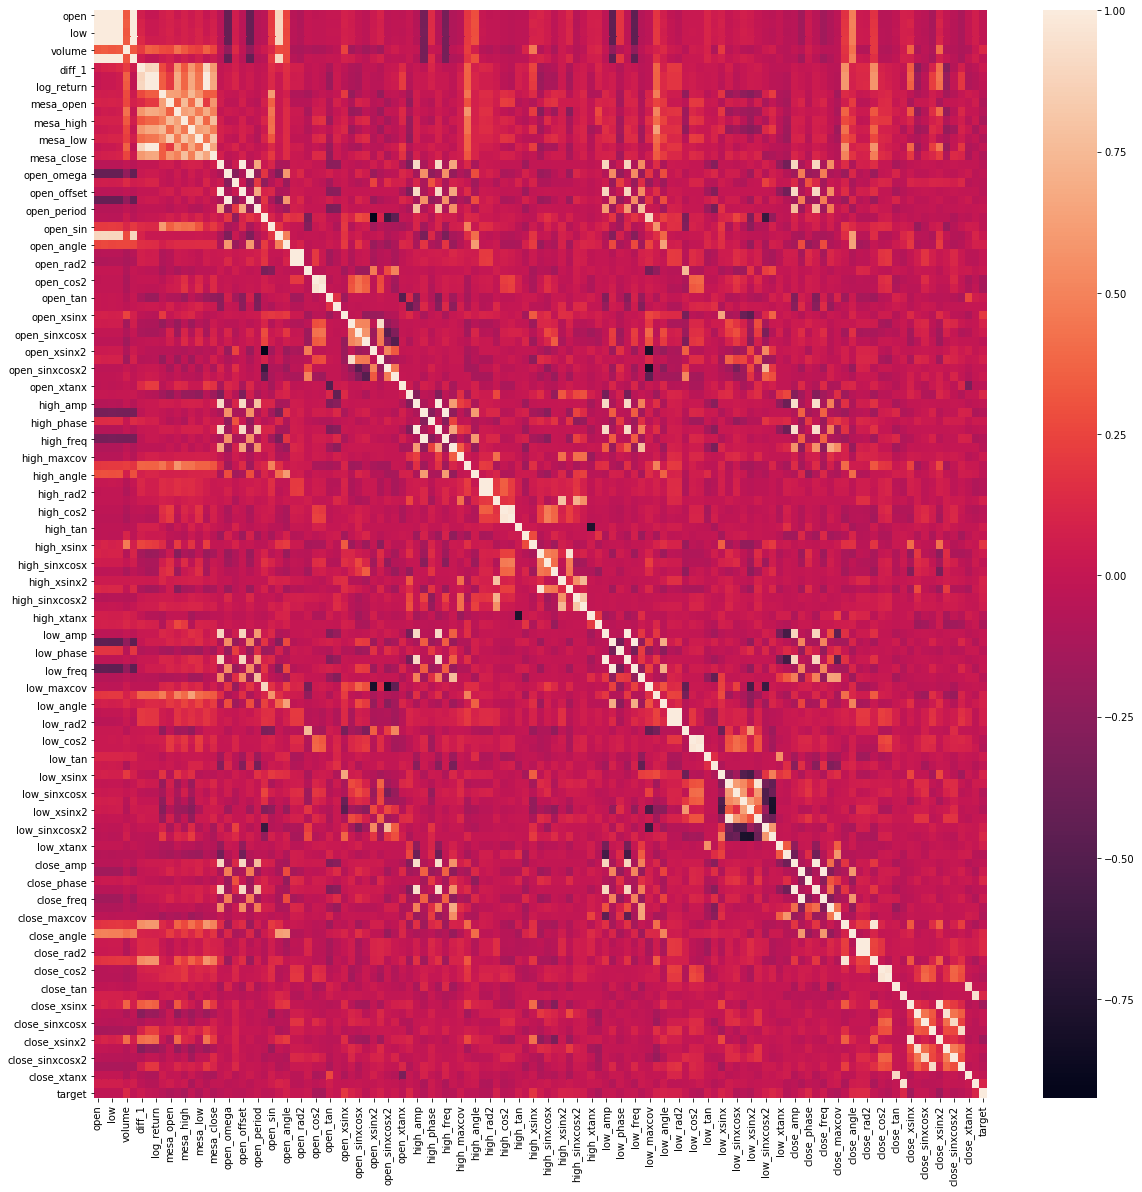

In [14]:
import seaborn as sns
plt.figure(figsize=(20, 20))
sns.heatmap(df.corr())

In [15]:
df.columns

Index(['open', 'high', 'low', 'close', 'volume', 'date', 'SYMBOL',
       'prev_close', 'diff_1', 'pct_change',
       ...
       'close_xcosx', 'close_sinxcosx', 'close_xsinxcosx', 'close_xsinx2',
       'close_xcosx2', 'close_sinxcosx2', 'close_xsinxcosx2', 'close_xtanx',
       'close_xtanx2', 'target'],
      dtype='object', length=129)

In [16]:
#x_cols = ['%close', 'mesa_close','%close_s','rad_angle']
x = df.dropna()
x = x.drop(['open_fitfunc','low_fitfunc','high_fitfunc','close_fitfunc','low_maxcov',
            'target',
            'date',
            'SYMBOL',
            'time'], axis=1)
#x = df.dropna()[['%close_s','next_%close', 'next_%close_cos', '%close_cos']]

y = df.dropna()['target']

x, y

(        open      high      low   close   volume  prev_close  diff_1  \
 251  202.240  209.8300  201.980  207.70  2590486      199.71    7.99   
 250  201.355  204.4600  197.210  199.71  1952648      199.38    0.33   
 249  194.220  203.8500  193.620  199.38  4048023      193.30    6.08   
 248  192.650  196.8800  189.120  193.30  4591084      191.82    1.48   
 247  197.510  199.8400  191.380  191.82  4488571      198.38   -6.56   
 ..       ...       ...      ...     ...      ...         ...     ...   
 29    60.620   62.2200   59.580   61.92  2229245       60.64    1.28   
 28    62.710   62.8900   60.130   60.64  2277572       62.39   -1.75   
 27    62.310   62.7000   61.540   62.39  1825121       62.61   -0.22   
 26    61.740   62.8599   60.610   62.61  2819114       61.72    0.89   
 25    64.700   64.7800   61.375   61.72  4429458       64.52   -2.80   
 
      pct_change  log_return     %open  mesa_open     %high  mesa_high  \
 251    0.040008    0.039228  0.004395   0.49163

In [17]:
x.describe()

,open,high,low,close,volume,prev_close,diff_1,pct_change,log_return,%open,mesa_open,%high,mesa_high,%low,mesa_low,%close,mesa_close,open_amp,open_omega,open_phase,open_offset,open_freq,open_period,open_maxcov,open_sin,open_angle,open_rad,open_rad2,open_sin2,open_cos2,open_cos,open_tan,open_tan2,open_xsinx,open_xcosx,open_sinxcosx,open_xsinxcosx,open_xsinx2,open_xcosx2,open_sinxcosx2,open_xsinxcosx2,open_xtanx,open_xtanx2,high_amp,high_omega,high_phase,high_offset,high_freq,high_period,high_maxcov,...,low_omega,low_phase,low_offset,low_freq,low_period,low_sin,low_angle,low_rad,low_rad2,low_sin2,low_cos2,low_cos,low_tan,low_tan2,low_xsinx,low_xcosx,low_sinxcosx,low_xsinxcosx,low_xsinx2,low_xcosx2,low_sinxcosx2,low_xsinxcosx2,low_xtanx,low_xtanx2,close_amp,close_omega,close_phase,close_offset,close_freq,close_period,close_maxcov,close_sin,close_angle,close_rad,close_rad2,close_sin2,close_cos2,close_cos,close_tan,close_tan2,close_xsinx,close_xcosx,close_sinxcosx,close_xsinxcosx,close_xsinx2,close_xcosx2,close_sinxcosx2,close_xsinxcosx2,close_xtanx,close_xtanx2
count,227.000000,227.000000,227.000000,227.000000,2.270000e+02,227.000000,227.000000,227.000000,227.000000,227.000000,227.000000,227.000000,227.000000,227.000000,227.000000,227.000000,227.000000,227.000000,227.000000,227.000000,227.000000,227.000000,227.000000,2.270000e+02,227.000000,227.000000,227.000000,227.000000,227.000000,227.000000,227.000000,227.000000,227.000000,227.000000,227.000000,227.000000,227.000000,227.000000,227.000000,227.000000,227.000000,227.000000,227.000000,227.000000,227.000000,227.000000,227.000000,227.000000,227.000000,2.270000e+02,...,227.000000,227.000000,227.000000,227.000000,227.000000,227.000000,227.000000,227.000000,227.000000,227.000000,227.000000,227.000000,227.000000,227.000000,227.000000,227.000000,227.000000,227.000000,2.270000e+02,227.000000,227.000000,2.270000e+02,227.000000,227.000000,227.000000,227.000000,227.000000,227.000000,227.000000,227.000000,2.270000e+02,227.000000,227.000000,227.000000,227.000000,227.000000,227.000000,227.000000,227.000000,227.000000,227.000000,227.000000,227.000000,227.000000,227.000000,227.000000,227.000000,227.000000,227.000000,227.000000
mean,106.760001,109.428620,104.251048,107.080969,3.308669e+06,106.450220,0.630749,0.005657,0.005150,0.005680,0.498602,0.005646,0.498779,0.005612,0.498615,0.005657,0.498662,0.730236,1.808090,-0.250605,0.791829,0.287766,29.522514,2.820837e+10,0.006888,231.946201,3.260399,3.548165,-0.002370,0.000379,-0.005826,-0.662064,0.325334,0.000467,0.000033,0.000804,-0.000030,-0.003518,-0.000905,-0.022155,-0.000553,-0.016202,0.004072,1.189330,1.558325,1.227578,1.271731,0.248015,45.152210,3.516039e+09,...,1.533728,0.907315,0.298078,0.244100,42.182067,0.006587,197.023524,3.158194,3.402294,-0.013565,-0.044010,-0.033367,-1.890225,0.478447,0.000427,0.000439,-0.000284,-0.000058,-5.138634e-03,0.001180,-0.029581,2.438572e-03,0.003126,0.035837,1.050078,1.467978,1.562992,1.065086,0.233636,62.177385,2.937121e+08,0.006369,198.172298,3.172120,3.405755,0.006543,-0.030694,-0.030644,0.792196,-4.960864,0.000361,0.001369,0.000143,-0.000011,0.000355,0.002189,-0.000034,-0.000002,0.035727,-0.072677
std,48.023470,49.278061,46.596642,48.087843,2.115262e+06,47.699675,3.872031,0.031649,0.031380,0.035670,0.027985,0.030234,0.023895,0.032313,0.026978,0.031649,0.025993,16.270636,0.883197,8.756610,16.186009,0.140565,259.491224,1.860531e+11,0.019964,130.075161,1.845944,1.857494,0.770891,0.735542,0.747499,11.361897,11.820162,0.001014,0.022330,0.012548,0.000542,0.032400,0.022809,0.677384,0.028642,0.783476,0.295188,18.078687,0.937572,8.761110,18.066898,0.149219,300.160692,3.470422e+10,...,0.878003,11.601609,19.744387,0.139739,316.168432,0.019085,127.452658,1.820884,1.833434,0.697730,0.729734,0.742923,18.985382,10.009397,0.000878,0.021957,0.013456,0.000689,4.717276e-02,0.021133,0.613265,4.169949e-02,0.554795,0.323825,21.455518,0.795524,9.175331,21.453211,0.126612,381.975232,4.123450e+09,0.017429,126.170172,1.791828,1.791762

In [18]:
x = sm.add_constant(x)
model = sm.OLS(y, x)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                 target   R-squared:                       0.612
Model:                            OLS   Adj. R-squared:                  0.374
Method:                 Least Squares   F-statistic:                     2.571
Date:                Tue, 25 Aug 2020   Prob (F-statistic):           3.26e-07
Time:                        17:14:39   Log-Likelihood:                 571.01
No. Observations:                 227   AIC:                            -968.0
Df Residuals:                     140   BIC:                            -670.0
Df Model:                          86                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.1219      0.071  

From visual and statistical analysis of this regression, I have come to the conclusion that this regression is of value. In the context of forecasting stock prices, doing better than the mean by 20% is quite good. 

This regression is simply a tool to grasp how much predictive value my current feature set may hold. However, it is not to be used in a standalone fashion. 

The top 4 identified features from this work so far include:
- The output of the sine function for today's (already known) % change
- The output of the sine function for tomorrow's (unknown) % change
- The output of the cosine function based on the computed radians for today (known) and tomorrow (calculated)

The strength of these correlations show that the work I have done so far has been worthwhile. I have created a few very strong relationships with tomorrow's outcome. 

In [24]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(x.drop('const',axis=1),y)
lr.score(x.drop('const',axis=1),y)

0.5480305358798974

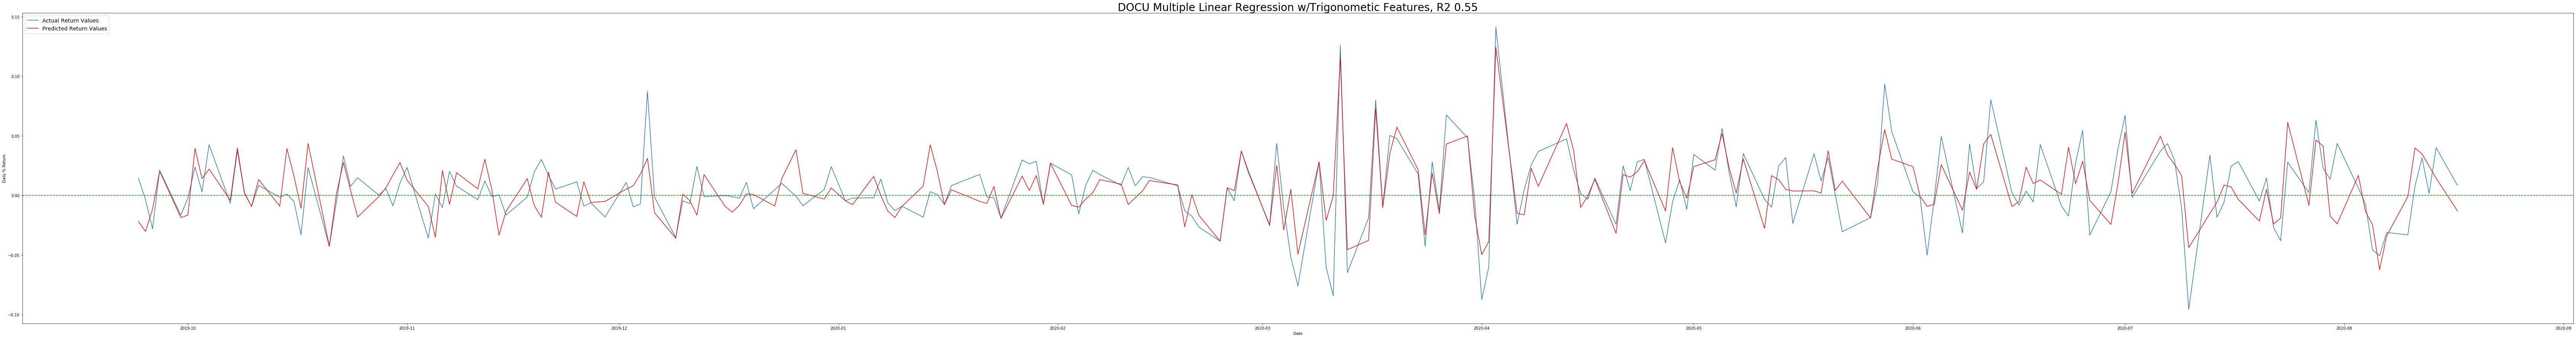

In [25]:
y_pred = lr.predict(x.drop('const',axis=1))

plt.figure(figsize=(120, 15))
plt.plot(df.loc[y.index, 'date'], y.reset_index()['target'], label='Actual Return Values')
plt.plot(df.loc[y.index, 'date'], y_pred, c='r', label='Predicted Return Values')
plt.axhline(0, c='g', linestyle='dashed')
plt.title('DOCU Multiple Linear Regression w/Trigonometic Features, R2 0.55', fontsize=28)
plt.xlabel('Date')
plt.ylabel('Daily % Return')
plt.legend(loc='upper left', fontsize=14)

Adding variables in multiple dimensions (open, high, low, close) improved results both visibly and statistically. While the adjusted R-2 score did not improve significantly, the R-2 itself did. Furthermore, the visual result appears to now closely match the graph of the data. It is still imperfect, and obviously to some extent the current methodology is flawed as there was no train test split. 

However, the underlaying model is still a linear regression, which begs to ask whether this level of accuracy does entail some actual learning about the relationships in the dataset? 

#### 4. Implement complex relationships

A few relationships remain which I would like to test. They are:

- x sin(x)  
- x cos(x)
- sin(x) cos(x)
- x sin(x) cos(x)

Furthermore, since volume may be a scaling factor which will be unknown, I would like to check if the model improves by dividing the return by the volume. 

At this point, it appears that we have modeled the progression in return very accurately. This model is not a predictive model since it has not been studied with train test split, but we will get to that in future notebooks. 

I also fit the model after dividing target by volume, but I found that many of the data points became to close to zero to impact the scoring function. The R2 score itself increased to .78, but that may have been because many points lay along the zero line at that point with little deviation. 

Instead, I will try scaling the entire dataset using standard scaler. 

Scaling does not appear to benefit the model in this case. 

Given the work done in this notebook, we have now made significant progress towards the goal of building a model that can predict the stock market. Many aspects, however (indeed the bulk of the work), remains to be done. 

In future notebooks we will:

-  Iteratively implement the features created in this notebook on many datasets
-  Transform datasets for novel machine learning implementations
-  Train and test the datasets on segmented groupings
-  Engineer scripts to put the finished model into production

#### To Do: invent more trigonomic relationships such as tanx, xtanx, and implement them as well. it looks like there is something missing. Just another piece of the puzzle and it might be in the tanx. 

After adding tanx, tanx2, xtanx, and xtanx2, the model performed slightly better still. It now appears to follow the return line almost perfectly, with few deviations in direction or magnitude. 